In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import functions.eddy_feedback as ef
import functions.data_wrangling as data

## Import data

In [2]:
path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded')
data_files = sorted(path.glob('*.nc'))

model_names = []
for item in data_files:
    
    file_stem = item.stem
    model = file_stem.split('_')[0]
    model_names.append(model)

ds = {}
for model in model_names:
    
    data_path = path / f'{model}_1.1_ubar_epfy_divFy.nc'
    
    dataset = xr.open_dataset(str(data_path))
    ds[model] = dataset

In [3]:
efp = {'model': [], 'efp': []}

for model in model_names:
    efp_value = ef.calculate_efp(ds[model], data_type='pamip')
    efp['model'].append(model)
    efp['efp'].append(efp_value)

df = pd.DataFrame(efp)

In [4]:
df['neck_wind'] = np.nan
df

,model,efp,neck_wind
0,CESM1-WACCM-SC,0.1297,NaN
1,CESM2,0.3693,NaN
2,CNRM-CM6-1,0.2421,NaN
3,CanESM5,0.4256,NaN
4,E3SMv1,0.0543,NaN
5,EC-EARTH3,0.2945,NaN
6,ECHAM6.3,0.0139,NaN
7,FGOALS-f3-L,0.2354,NaN
8,HadGEM3-GC31-LL,0.2730,NaN
9,HadGEM3-GC31-MM,0.3137,NaN


In [5]:
neck_winds = {}
for model in model_names:
    
    # Handle ensembles if present
    if 'ens_ax' in ds[model].dims:
        ubar = ds[model].ubar.mean('ens_ax')
        ubar = data.seasonal_mean(ubar, season='djf')
    else:  # Handle datasets with ensembles as separate years
        ubar = ds[model].ubar
        ubar = data.seasonal_mean(ubar, season='djf')
        ubar = ubar.mean('time')
    
    u_neck = ubar.sel(level=70, method='nearest').sel(lat=slice(45,55)).mean('lat')
    # neck_winds[model] = np.mean(u_neck.values).round(3)
    df.loc[df['model'] == model, 'neck_wind'] = np.mean(u_neck.values).round(3)

In [ ]:
df = df[df["model"] != "ECHAM6.3"]
df

,model,efp,neck_wind
0,CESM1-WACCM-SC,0.1297,17.660000
1,CESM2,0.3693,17.052000
2,CNRM-CM6-1,0.2421,13.709000
3,CanESM5,0.4256,22.422001
4,E3SMv1,0.0543,10.813000
5,EC-EARTH3,0.2945,15.677000
7,FGOALS-f3-L,0.2354,14.620000
8,HadGEM3-GC31-LL,0.2730,22.396999
9,HadGEM3-GC31-MM,0.3137,21.104000
10,IPSL-CM6A-LR,0.2719,18.520000


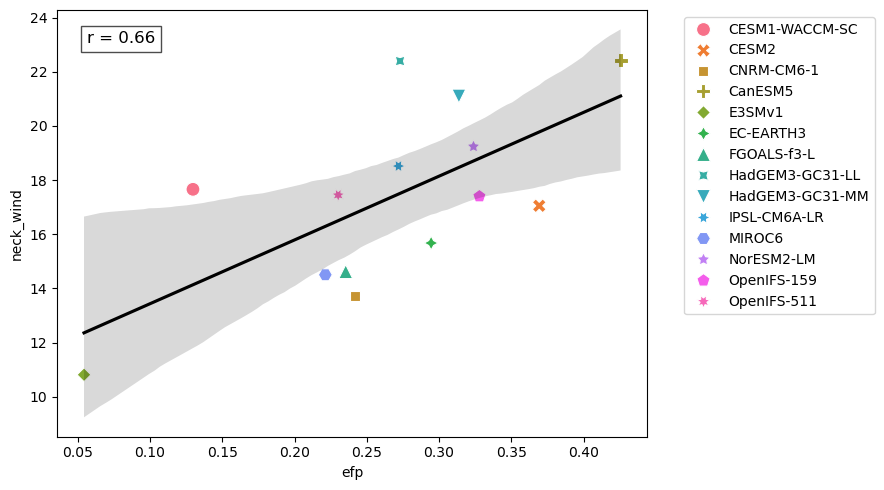

In [7]:
fig, ax = plt.subplots(figsize=(9,5))

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)  # Compute Pearson correlation
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

sns.scatterplot(
    x=df['efp'],
    y=df['neck_wind'],
    hue=df['model'],
    style=df['model'],
    s=100,
    ax=ax
)
sns.regplot(
    x=df['efp'],
    y=df['neck_wind'],
    scatter=False,
    color='k',
    #ci=None,
    ax=ax
)

# Add correlation to the figure
add_correlation(ax, df['efp'], df['neck_wind'])

# Add legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [8]:
for i in range(1,6):
    print(i)

1
2
3
4
5
